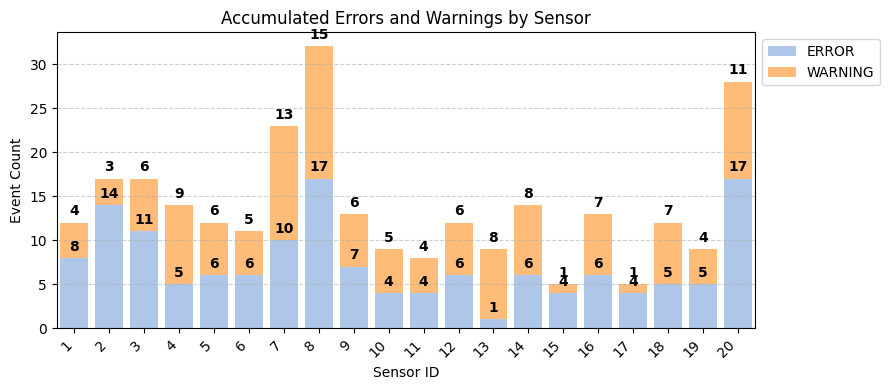

Stopped by user


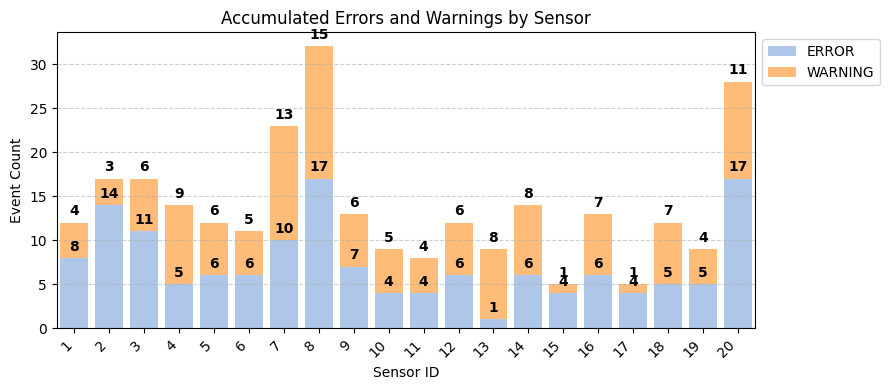

In [2]:
"""
sensor_logs_dashboard

Real-time dashboard to visualize Kafka sensor log events (ERRORs and WARNINGs).
Reads from the 'log-data' Kafka topic and displays an updating bar chart of
accumulated counts per sensor in a Jupyter notebook environment.
"""

from IPython.display import clear_output, display
import json
import time
from collections import Counter
import matplotlib.pyplot as plt
from confluent_kafka import Consumer

# --- Kafka configuration ---
# Define connection parameters and subscribe to the log-data topic
conf = {
    "bootstrap.servers": "localhost:9092",   # Kafka broker address(es)
    "group.id": "log-vis-group",             # Consumer group identifier
    "auto.offset.reset": "latest",           # Start from latest messages
}
consumer = Consumer(conf)
consumer.subscribe(["log-data"])

# --- In-memory counters ---
# Track number of ERROR and WARNING messages per sensor
error_counts = Counter()    # sensor_id -> error count
warning_counts = Counter()  # sensor_id -> warning count

# --- Plot setup ---
# Create the matplotlib Figure and Axes once, to update live
fig, ax = plt.subplots(figsize=(9, 4))

def update_plot():
    """
    Redraw the bar chart with enhanced styling:
    - Sensors sorted by descending total events.
    - Stacked bars colored via a colormap.
    - Rotated x-tick labels.
    - Light grid background.
    - Legend positioned outside plot.
    - Value labels above each segment.
    """
    ax.clear()

    # Combine and sort sensor IDs by total events descending
    sensor_ids = sorted(
        set(error_counts) | set(warning_counts),
        key=lambda s: error_counts[s] + warning_counts[s],
        reverse=True
    )
    errs  = [error_counts[s]   for s in sensor_ids]
    warns = [warning_counts[s] for s in sensor_ids]

    # Define colors from a colormap
    cmap = plt.get_cmap('tab20')
    color_err = cmap(1)
    color_warn = cmap(3)

    # Plot stacked bars
    bars_err = ax.bar(sensor_ids, errs, label="ERROR", bottom=[0]*len(errs),
                      color=color_err)
    bars_wrn = ax.bar(sensor_ids, warns, label="WARNING", 
                      bottom=errs, color=color_warn)

    # Grid, labels and title
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xticks(sensor_ids)
    ax.set_xlim(0.5, max(sensor_ids, default=0) + 0.5)
    ax.set_xlabel("Sensor ID")
    ax.set_ylabel("Event Count")
    ax.set_title("Accumulated Errors and Warnings by Sensor")

    # Rotate x labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Move legend outside
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Annotate each bar segment with its count above the bar
    for err_bar, wrn_bar, e, w in zip(bars_err, bars_wrn, errs, warns):
        # Error count
        ax.annotate(f"{e}",
                    xy=(err_bar.get_x() + err_bar.get_width() / 2, e),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontweight="bold")
        # Warning count
        ax.annotate(f"{w}",
                    xy=(wrn_bar.get_x() + wrn_bar.get_width() / 2, e + w),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontweight="bold")

    plt.tight_layout()

# --- Main loop: consume and update ---
try:
    last_redraw = time.time()  # timestamp of last plot refresh

    while True:
        # Poll Kafka for new messages, timeout after 200ms
        msg = consumer.poll(0.2)
        if msg and msg.value():
            # Parse message JSON and extract sensor_id and log level
            entry = json.loads(msg.value())
            sid = entry.get("sensor_id")
            level = entry.get("level")

            # Increment corresponding counter
            if level == "ERROR":
                error_counts[sid] += 1
            elif level == "WARNING":
                warning_counts[sid] += 1

        # Redraw the chart at 1-second intervals
        if time.time() - last_redraw >= 1.0:
            clear_output(wait=True)     # clear previous cell output
            update_plot()               # redraw with updated counts
            display(fig)                # show in notebook
            last_redraw = time.time()   # update timestamp

finally:
    # Ensure consumer is properly closed on exit
    consumer.close()